## Get a simple data set object together

In [1]:
import tensorflow as tf
from keras.layers import Conv2D, LeakyReLU, Input, Dense, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
import keras
import matplotlib.pyplot as plt

In [2]:
#Make the dataset
from cycleganstyletransfer.config import DATA_DIR
data_dir = DATA_DIR / "raw"


my_monet_ds_train, my_monet_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Monet",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

my_image_ds_train, my_image_ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir / "Images",
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(128, 128),
    batch_size = 1,
    labels = None,
)

DATASET_HEIGHT = max(len(my_monet_ds_train), len(my_image_ds_train))

my_monet_ds_train = iter(my_monet_ds_train.shuffle(42).repeat())
my_image_ds_train = iter(my_image_ds_train.shuffle(42).repeat())

2025-06-06 19:36:08.677 | INFO     | cycleganstyletransfer.config:<module>:11 - PROJ_ROOT path is: C:\Users\willi\Desktop\AIPortfolio\CycleGanV2\cycleganstyletransfer


Found 1193 files belonging to 1 classes.
Using 955 files for training.
Using 238 files for validation.
Found 7037 files belonging to 1 classes.
Using 5630 files for training.
Using 1407 files for validation.


## Put the model together

In [8]:
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape, batch_size=32)
    
    # First layer doesn't use instance normalization
    x = Conv2D(32, 3,padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(64, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(128, 3,padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D(2)(x)

    x = Conv2D(1, 3, padding='same')(x)

    #x = Flatten()(x)
    #x = GlobalAveragePooling2D()(x)
    #x = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs, x, name='discriminator')

my_discriminator = build_discriminator()
my_discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(32, 128, 128, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 128, 128, 32)        896       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (32, 128, 128, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 64, 64, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (32, 64, 64, 64)          18496     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (32, 64, 64, 64)          0         
                                                     

In [9]:
def my_square_loss(y_true, y_pred):
    y_true = tf.reshape(tf.cast(y_true, tf.float32), (-1, 1, 1, 1))
    y_true = tf.broadcast_to(y_true, tf.shape(y_pred))
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))



Epoch 1/3
Step 1876/1876 - loss: 0.7772
Epoch 1 completed in 593s - avg loss: 3.5344

Epoch 2/3
Step 1876/1876 - loss: 0.2544
Epoch 2 completed in 1242s - avg loss: 0.3748

Epoch 3/3
Step 1876/1876 - loss: 0.3069
Epoch 3 completed in 897s - avg loss: 0.2441


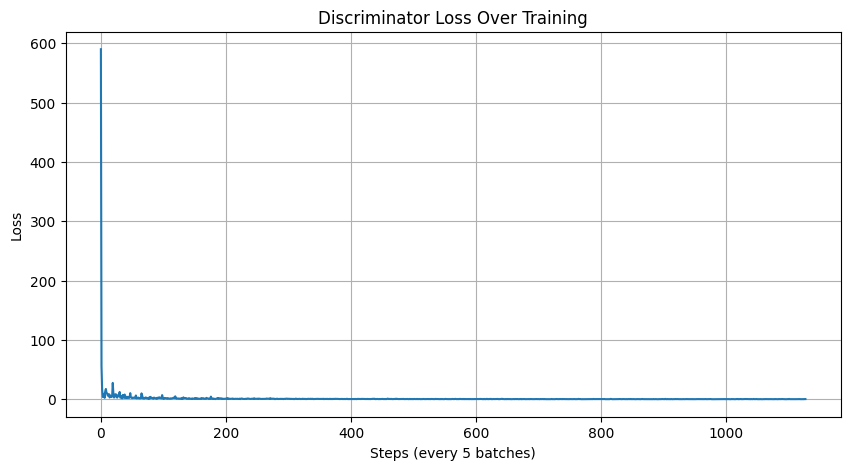

In [10]:
from keras.optimizers import Adam
import numpy as np
import time

NUM_EPOCHS = 3
EPOCH_LENGTH = DATASET_HEIGHT // 3
DISPLAY_INTERVAL = 5  # record loss every 5 steps

my_optimiser = Adam(learning_rate=0.0002, beta_1=0.5)

all_losses = []

for i in range(NUM_EPOCHS):
    print(f"\nEpoch {i + 1}/{NUM_EPOCHS}")
    epoch_losses = []
    start_time = time.time()

    for j in range(EPOCH_LENGTH):
        monet_image = (next(my_monet_ds_train)) 
        real_image = (next(my_image_ds_train))

        with tf.GradientTape() as tape:
            monet_output = my_discriminator(monet_image)
            image_output = my_discriminator(real_image)

            loss = 0.5 * (
                my_square_loss(tf.constant(1.0), monet_output) +
                my_square_loss(tf.constant(0.0), image_output)
            )

        grads = tape.gradient(loss, my_discriminator.trainable_variables)
        my_optimiser.apply_gradients(zip(grads, my_discriminator.trainable_variables))

        if j % DISPLAY_INTERVAL == 0:
            epoch_losses.append(tf.squeeze(loss).numpy())
        print(f"\rStep {j + 1}/{EPOCH_LENGTH} - loss: {epoch_losses[-1]:.4f}", end='')

    epoch_avg_loss = np.mean(epoch_losses)
    print(f"\nEpoch {i + 1} completed in {int(time.time() - start_time)}s - avg loss: {epoch_avg_loss:.4f}")
    all_losses.extend(epoch_losses)

# Plot full training loss curve
plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.title('Discriminator Loss Over Training')
plt.xlabel(f'Steps (every {DISPLAY_INTERVAL} batches)')
plt.ylabel('Loss')
plt.grid(True)
plt.show()